# Opsin Model Toolkit

This notebook shows how to use the opsin-toolkit to generate a model that describes the current response of a neuron that express opsin on its membrane.

This toolkit is written to analize a set of power curves, i.e. current curves obtained with laser pulses at different powers, measure some parameters and build a model with them.

This model can be then adjusted manually to best fit the powercurves.

In [1]:
import sys
# include the toolkit path in the modules paths
sys.path.append('../scripts')

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from IPython.html.widgets import interact

import quantities as pq

# maths
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# the opsin-model toolkit
import marco_tools as mt

# plotting constants
FIG_BIG = (15,15)
FIG_H = (15,7)
FIG_SMALL = (7,7)

# help setting the text in a plot
def default_plot_setup(title='Title', xlabel='x',ylabel='y'):
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);


/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


**load experimental data**

The datafile name is "cell_100_ChR2.txt". Data was taken by Rossella.

cell type: CHO culture
ILLUMINAION: holograpic 1p (setup 3i) (vecchia configurazione: banco ottico di Osnath).
CURRENTS: recorded with holographic photo-stimulation with cell shape (the shape completely covered the cell).

In [4]:
# ExperimentFolder is an object that looks for experiment files in a given folder
folder = mt.ExperimentFolder("../experimental/")
filename = folder.file_names_as_string_list[2]

# ExperimentFile is an object that loads data from a CSV file
efile = mt.ExperimentFile(folder.folder, filename)
print filename

cell_100_ChR2.txt


In [5]:
efile.column_data[1]

array([-3.815779 ,  7.170548 , -0.1536706, ..., -1.984724 , -3.815779 ,
        7.170548 ])

In [6]:
plt.figure(figsize=FIG_H)
default_plot_setup(title='Current',ylabel='Current',xlabel='Time')


# power values of light pulse (Given by Rossella. (What unit?) )
powervalues = np.array([
0.0836012861736334,
0.0498392282958199,
0.0249196141479099,
0.0160771704180064,
0.0128617363344051,
0.00803858520900321,
0.00643086816720257,
0.00321543408360128,
0.00160771704180064,
])
powervalues = powervalues[::-1]

# End time of light pulse for each powercurve
pulse_end_times = np.array([
225,215,205,195,185,175,165,155,135
])

# ExperimentCollection is an object that contains several experiments
# OpsinExperiment is an objects that contains the experiment data and properies
exps = mt.ExperimentCollection()
for i in range(efile.column_number):
    # create a new experiment. Data begins at t=0 and ends at t=500 (ms)
    #xdata = pq.Quantity(np.linspace(0,500,len(efile.column_data[0])),pq.ms)
    xdata = np.linspace(0,500,len(efile.column_data[0]))
    e = mt.OpsinExperiment(efile.column_data[i], xdata=xdata)
    
    # set the data of this experiment to the next column of the experimental file
    # e.set_current(n=i,step=2,mean_between_steps=True)
    
    ### SELECT THIS PULSE
    e.select_by_time(100, 400)
    
    # invert the data (current is now positive)
    e.y.invert()
    
    # set the laser pulse start and end time
    e.pulse_start = 116
    e.pulse_end = pulse_end_times[i]
    
    #e.current.norm_to_constant(250)
      
    # remove the last some points which may contain glitches
    # e.select_by_data_points(0,-10)
    
    e.light_power = powervalues[i]
    e.update_raw_data_from_current()
    
    exps.append(e)

# PLOT    
for e in exps:
    plt.plot(e.x,e.y,'.')
    
#plt.axis([0,500,-0.2,1.3]);

# OpsinFit is an object that helps fitting these parameters.
fit = mt.OpsinFit(e)
fit.fit_parameter("max_current", start_fit_time=115.5, end_fit_time=115.5+4)
fit_result = fit.model("max_current")
bnd = fit.fit_bnds("max_current")
norm_param = fit.max_current

plt.plot(np.linspace(0,500,100),[norm_param]*100,'--',label="max current in a two level system = {}".format(int(round(norm_param))));
plt.plot(fit_result[0],fit_result[1],'k--',label="exponential fit of the highest power curve")
plt.plot(bnd[0],bnd[1],'ko')

plt.legend();

../scripts/marco_tools/Experiment.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if xdata == None:
/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/scipy/optimize/minpack.py:601: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## NORMALIZATION

The model must be carefully dimensioned.
Here we use a population model, where the current is equal to the population in the Open state. The max value of the current corresponds to having all the channels in the Open state. Knowing the total number of channels (i.e. max current) is essential for dimensioning the model.
**The problem is that this value is not directly inferable from the data**.

But:
The simplest model, where only a Closed-to-Open state transition is considered, reaches this max value asimptotically with an exponential low.

If tau_on << tau_off (which is true for high light power values), up to a fraction of tau_off, the dynamic can be considered that of the simple model just described.

This is why we estimate this normalization parameter with a fit of a simple Closed-to-Open model on the courve corresponding to the highest power. This fit is done over 4 ms (tau_off ~ 25ms). [see previous figure]

The asymptotical value of this fit is taken as the max current value.

# Patameter extraction

We measure the tau ON and OFF parameters by fitting the data with exponential curves.

tau_on and tau_off are measured in this way for each courve

In [28]:
plt.figure(figsize=FIG_BIG)

plots = len(exps)
cols = 3
rows = plots/cols

pulse_end_times = []
tau_ons = []
tau_offs = []
sstate = []

for i,e in enumerate(exps):
  
    # fit tau_on and tau_off
    fit.e = e
    fit.fit_parameter("tau_on",start_fit_time=116,end_fit_time=116+3)
    fit.fit_parameter("tau_off", end_fit_time=400)
    
    pulse_end_times.append(e.pulse_end)

    
    tau_ons.append(fit.tau_on)
    tau_offs.append(fit.tau_off)

    # theoretical statdy state
    k_on = 1.0/fit.tau_on
    k_off = 1.0/fit.tau_off
    sst = k_on/(k_on+k_off)*norm_param
    sstate.append(sst)
    
    
    plt.subplot(rows,cols,i+1)
    default_plot_setup(title= 'power= ' + str(round(e.light_power,3)),xlabel='',ylabel='')

    plt.plot(e.x, e.y, label=e.light_power )
    plt.plot(fit.model("tau_off")[0],fit.model("tau_off")[1],'r')
    plt.plot(fit.model("tau_on")[0],fit.model("tau_on")[1],'k', label="1-exp")
    plt.plot(fit.fit_bnds("tau_off")[0],fit.fit_bnds("tau_off")[1],'ro')
    plt.plot(fit.fit_bnds("tau_on")[0],fit.fit_bnds("tau_on")[1],'yo')
    plt.plot(np.linspace(0,500,100),[sst]*100,'--g',label='2 levels steady state')

    plt.legend()

    plt.axis([0,450,-20,norm_param+10])
    

    
plt.show()
# store the mean value of tau off
tau_off = np.mean(tau_offs)
#tau_on = np.mean(tau_ons)
print "media tau_off", np.mean(tau_offs)
print "media tau_on", np.mean(tau_ons)




media tau_off 22.5865691782
media tau_on 8.96048317718


## States

Let's point out the role of tau_on and tau_d, which are the caracteristic time of the Closed-to-Open state and Open-to-Desensitized state transitions respectively.



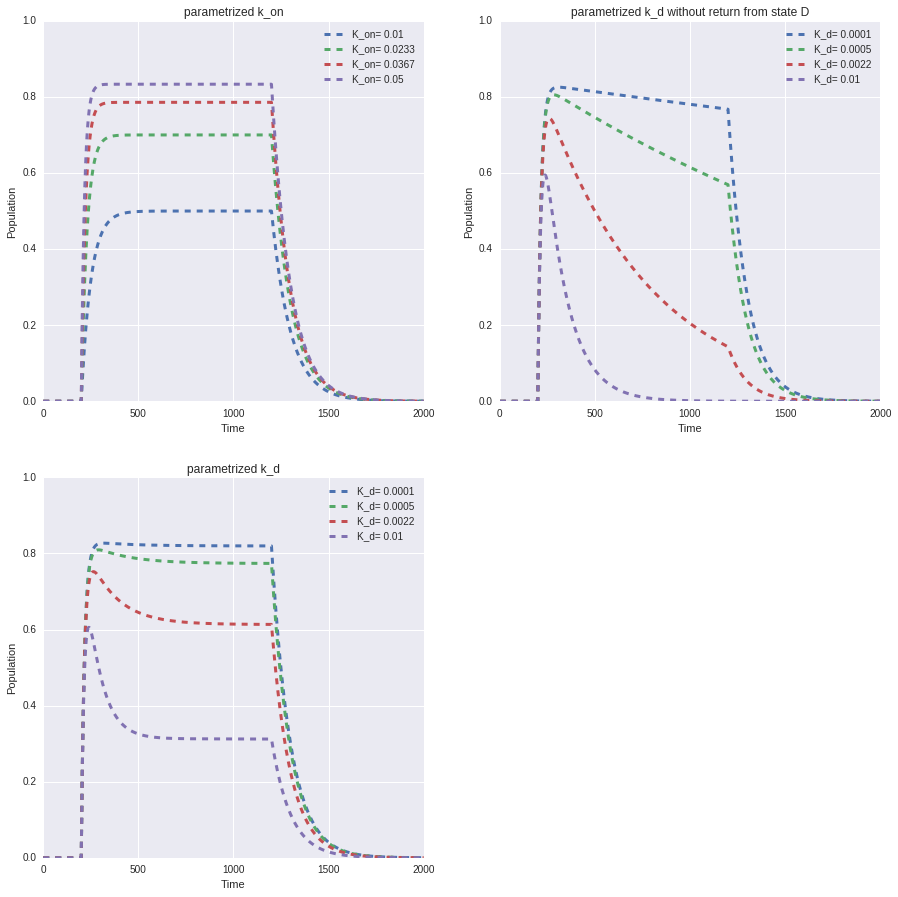

In [29]:
plt.figure(figsize=FIG_BIG)

K_off = np.zeros([3,3])
K_on = np.zeros([3,3])
# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state



K_off[O,C] = 0.01
K_on[O,C] = 0.01

K_on[C,O] = 0.01

pulse = mt.Pulse(200,1000,10000)
t = np.linspace(0,2000,10000)

plt.subplot(2,2,1)
default_plot_setup(title='parametrized k_on',xlabel='Time',ylabel='Population')

for k in np.linspace(0.01 ,0.05 ,4):
    K_on[C,O] = k
    v = odeint(mt.ode_model_generic,[1,0,0], t,(K_off,K_on,pulse),hmax=10)
    plt.plot(t,v[:,1],'--',linewidth='3', label='K_on= '+str(round(k,4)));


plt.axis([0,max(t),0,1])
plt.legend()

plt.subplot(2,2,2)
default_plot_setup(title='parametrized k_d without return from state D',xlabel='Time',ylabel='Population')    

for d in np.logspace(-4 ,-2 ,4):
    K_on[O,D] = d
    #K_on[D,O] = d/4
 
    v = odeint(mt.ode_model_generic,[1,0,0], t,(K_off,K_on,pulse),hmax=10)
    plt.plot(t,v[:,1],'--',linewidth='3', label='K_d= '+str(round(d,4)));

plt.axis([0,max(t),0,1])
plt.legend()

plt.subplot(2,2,3)
default_plot_setup(title='parametrized k_d',xlabel='Time',ylabel='Population')    
    
for d in np.logspace(-4 ,-2 ,4):
    K_on[O,D] = d
    K_on[D,O] = 0.005
    
    v = odeint(mt.ode_model_generic,[1,0,0], t,(K_off,K_on,pulse),hmax=10)
    plt.plot(t,v[:,1],'--',linewidth='3', label='K_d= '+str(round(d,4)));
    
plt.axis([0,max(t),0,1])
plt.legend();

* **top left**: increasing values of K_on (decreasing t_on) with fixed value of t_off results in an increase of the steady state current in a simple 2 states system

* **top right**: a 3 state system where from Open state it is possible to go to a Desensitized state, but the opposite trasition is not allowed. Increasing Kd lowers the peak current. No steady state is reached.

* **bottom left**: a 3 state system where from Open state it is possible to go to a Desensitized state and back from D to O. Now current reaches a steady state value again.

## Taus vs light power

Here follows a plot of the values of tau ON and tau OFF that we have just measured, against the light power.

BaseException: 

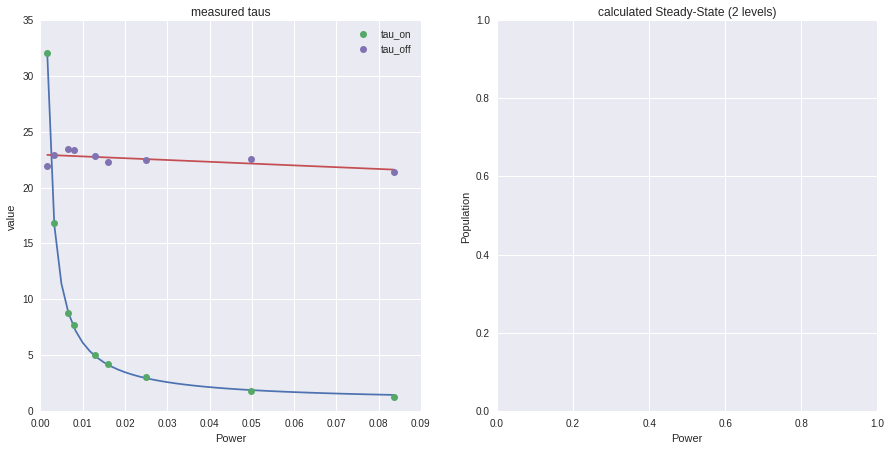

In [31]:
plt.figure(figsize=FIG_H)

x=np.linspace(min(powervalues),max(powervalues))

plt.subplot(1,2,1)
default_plot_setup(title='measured taus',ylabel='value',xlabel='Power')    
def func_on(x,m,q,c):
    return m / (x + q) + c

popt_on, pcov_on = curve_fit(func_on, powervalues, np.array(tau_ons))

plt.plot(x, func_on(x,popt_on[0],popt_on[1],popt_on[2]),'-')
plt.plot(powervalues, tau_ons,'o',label='tau_on')

# plt.axis([0,0.1,0,30])

def func_off(x,m,q):
    return m *x + q

popt_off, pcov_off = curve_fit(func_off, powervalues, np.array(tau_offs))
plt.plot(x, func_off(x,popt_off[0],popt_off[1]),'-')
plt.plot(powervalues, tau_offs,'o',label='tau_off')


plt.legend()
# plt.axis([0,0.1,0,50]);



plt.subplot(1,2,2)
default_plot_setup(title='calculated Steady-State (2 levels)',xlabel='Power',ylabel='Population')    

def func2(x,a,b,c):
    # see how tau_on depends on light power and the formula of 2 level steady state
    return (x+a)/(x+b) + c

try:
    popt, pcov = curve_fit(func, powervalues, np.array(sstate))
    plt.plot(x, func2(x,popt[0],popt[1],popt[2]),'-')
except:
    raise(BaseException)

plt.plot(powervalues,sstate,'o');

In [40]:
tau_offs


[21.931484486012955,
 22.935693864302824,
 23.465461483717039,
 23.396700208133439,
 22.86616609734709,
 22.295089476597294,
 22.475972043443022,
 22.520554462350166,
 21.392000482148191]

* **left** : tau on and tau off with their respective fits
* **right** : steady state current value for a 2 level state with this tau on and off

# Model fitting

<!-- <img src="imgs/3levels_model.svg" width="30%"> -->

First we define a coefficient matrix.

Each element of this matrix speciefies a transition coefficient (ex. k[O,C] is the coefficient of the transition from Open to Closed state).

Since we use a 3 level system, the matrix dimension is 3x3.

There are 2 of those matrices: k_on and k_off. They contain the values of the transition coefficients when light is on or off respectively.

In [32]:
lightpower = 1

# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state

# TRANSITION RATES
K_off = np.zeros([3,3]) # transition coefficient MATRIX when light is OFF
K_on =  np.zeros([3,3]) # transition coefficient MATRIX when light is ON

tau = tau_off #17.9 # usually called "tauoff" [ms] Exp Physiol. 2011 Jan; 96(1): 19–25. 
k = 1.0/tau

beta = (k*0.7-k/3)/(powervalues[-1]-powervalues[0])# fit parameter

K_off[O,C] = k
K_on[O,C] = k # this transition does not depend on light

#K_off[C,O] = 0
#K_on[C,O] = k

#K_off[O,D] = 0
#K_on[O,D] = lightpower*beta

#K_off[D,O] = k/30
#K_on[D,O] = K_off[D,O] # k/30

**Model parameter vs. light power**
Since tau_off does not vary mouch with the light power, we take its average as fixed value.

The value of tau_on is calculated with the best fit courbe obtained in the previous section.

In a 3 level system we still have to give a value to Kd. Apparently (but this is just empirical observation) a linear dependance of Kd vs. the light power seems to hold.

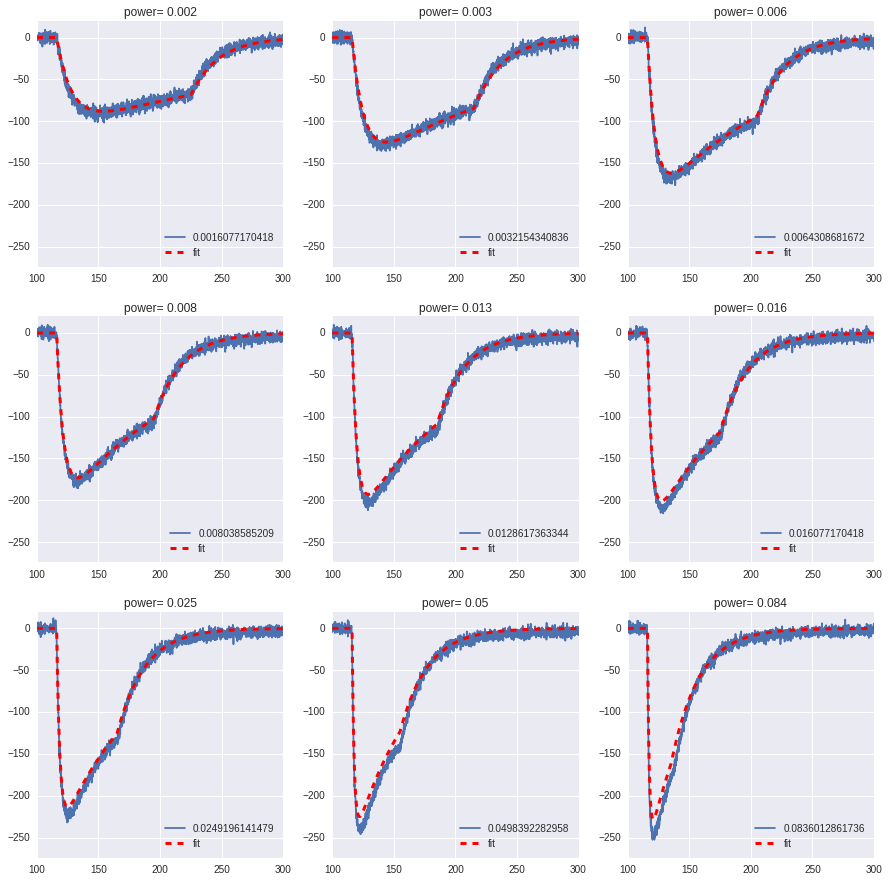

In [35]:
fig = plt.figure(figsize=FIG_BIG)
initial_condition = [norm_param,0,0]
# End times for the pulses
#pulse_end_times = np.array([
#225,215,205,195,185,175,165,155,135
#])

kd = []
INVERT = -1 # 1 not to invert, -1 to invert the current sign when plotting

for n_data,e in enumerate(exps):
    plt.subplot(rows,cols,n_data+1)
    default_plot_setup(title= 'power= ' + str(round(e.light_power,3)),xlabel='',ylabel='')

    lightpower = powervalues[n_data]       # set the light dependent parameters
    
    
    # UPDATE TAUS according to the light power
    this_tau_on = func_on(lightpower,popt_on[0],popt_on[1],popt_on[2])
    K_on[C,O] = 1.0/this_tau_on   #(tau_ons[n_data])
    K_on[O,D] = lightpower*beta+0.011
    
    
    #kd.append(K_on[O,D])

    # SOLVE THE DIFFERENTIAL EQUATION SYSTEM with the given parameters
    pulse_duration = e.pulse_end-e.pulse_start
    #print pulse_duration
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    t = e.x
    v = odeint(mt.ode_model_generic,initial_condition,t,(K_off,K_on,pulse),hmax=10)

    plt.plot(t,INVERT*e.y,label=e.light_power);
    plt.plot(t,INVERT*v[:,1],'r--',linewidth='3',label='fit');
#     plt.axis([100,300,0,1])
    if INVERT <0:
        plt.axis([100,300,-norm_param,20])
    else :
        plt.axis([100,300,0,norm_param])
    
    plt.legend(loc=4);